In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import math
import matplotlib.patches as patches

# ABM calibration with loss functions and optimisation algorithms

This tutorial is inspired by the paper 'Automated multi-objective calibration of biological agent-based simulations' (Read et al., 2016), which uses the Kolmogorov-Smirnov (KS) test in conjunction with optimisation algorithms to minimise the difference in results produced by simulations compared to those produced by in vivo experiments. Deconstructing the KS test and explaining each step was inspired by a Youtube video by Statistik und Archäologie – meistens mit R. The video is available at: https://www.youtube.com/watch?v=iy-ZVRUGCIs.

In [2]:
# Make style adjustments for plots

sns.set(style="ticks", context="talk", font_scale=2)
plt.style.use("dark_background")
plt.figure(figsize=(500,500))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.rcParams.update({'font.size': 20})

<Figure size 36000x36000 with 0 Axes>

In [3]:
"""
Initialise parameters for the demonstration
Two distributions will be generated and tested for similarity
These distributions are created with different means and standard deviations
"""

# Define distribution range
demo_min = 0
demo_max = 20

# Distribution 1
first_distribution_mean = 10
first_distribution_std = 3
first_distribution_number_samples = 2000

# Distribution 2
second_distribution_mean = 13
second_distribution_std = 4
second_distribution_number_samples = 2000

In [4]:
# Generate first distribution

first_normal_random_list = []

while len(first_normal_random_list) < first_distribution_number_samples:
    random_number = int(np.random.normal(loc=first_distribution_mean, 
                                         scale=first_distribution_std))
    
    if demo_min <= random_number <= demo_max:
        first_normal_random_list.append(random_number)

In [5]:
# Generate second distribution

second_normal_random_list = []

while len(second_normal_random_list) < second_distribution_number_samples:
    random_number = int(np.random.normal(loc=second_distribution_mean, 
                                        scale=second_distribution_std))
# Uncomment the lines below to generate a gamma instead of normal distributi
#     random_number = int(np.random.gamma(second_distribution_mean, 
#                                          second_distribution_std))
    
    if demo_min <= random_number <= demo_max:
        second_normal_random_list.append(random_number)

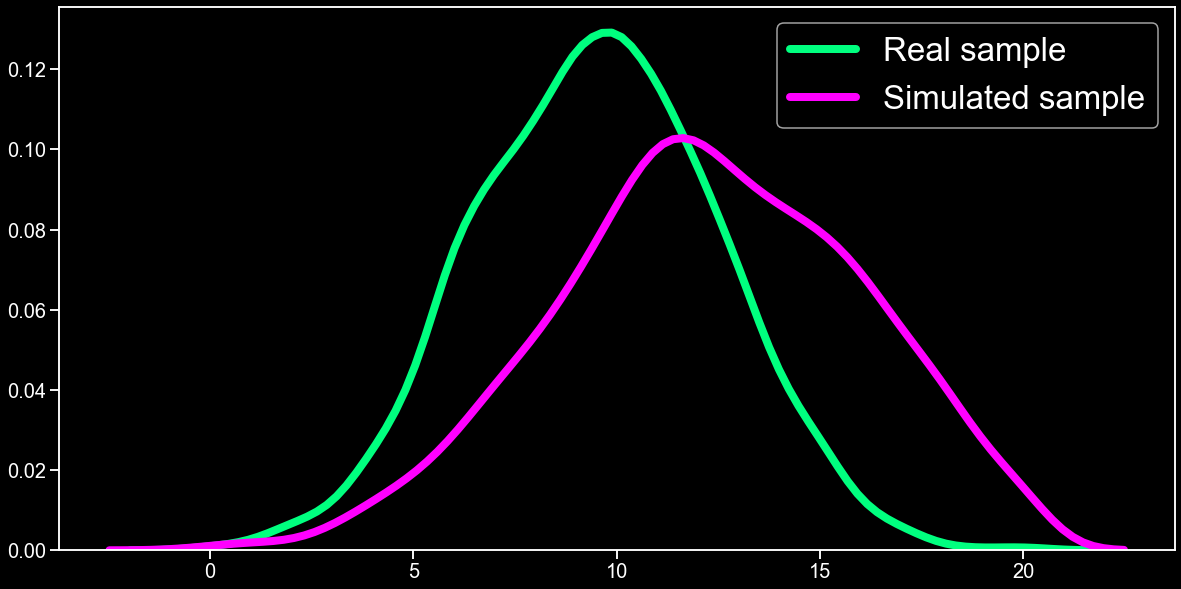

In [7]:
"""
Plot the two distributions. Here I am using KDE plots which smooth over the detail
and therefore are not as informative as histograms. However they are good for getting
a sense of the 'sameness' of the distribution. Histrograms to follow.
"""

ax = plt.subplots(figsize=(20, 10))
ax = sns.kdeplot(first_normal_random_list, 
            color='SpringGreen', 
            shade=False, 
            label='Real sample',
            linewidth=8)
ax = sns.kdeplot(second_normal_random_list, 
            color='magenta', 
            shade=False, 
            label='Simulated sample',
            linewidth=8)

Some background information on the KS test:

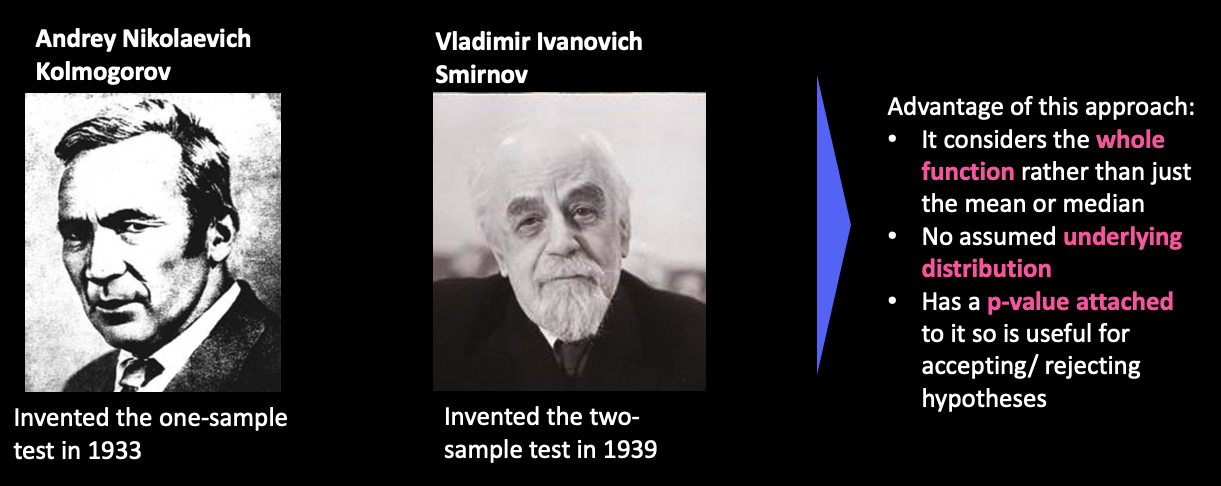

Sources:

Photos: https://www.risknet.de/en/wissen/whos-who/andrei-nikolajewitsch-kolmogorow/, https://www.groundai.com/project/vladimir-ivanovich-smirnov-1887-1974/1 

History: https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-32833-1_214

Test description:: http://www.mit.edu/~6.s085/notes/lecture5.pdf

In [12]:
# Here's how to compute KS using a built in library

computed_ks = stats.ks_2samp(first_normal_random_list, second_normal_random_list)
print(computed_ks)

KstestResult(statistic=0.338, pvalue=1.3026589109451891e-101)


The ks_2samp function returns a statistic for the maximum discrepancy between the two distributions. It also returns a p-value for rejecting the null hypothesis that the two samples are drawn from the same distribution. A threshold of 0.05 is commonly, albeit arbitrarily, used as a cut-off so that if the p-value is less than 0.05 we would say that we can reject the null hypothesis at the 5% confidence level.

Next we will dive into what is happening behind the scenes with the KS test.

In [8]:
# First define bins for the data we generated

bins = np.linspace(demo_min, demo_max, demo_max-demo_min+1)
print(bins)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


In [9]:
# Next we place the data into these bins

series_1_binned = np.histogram(first_normal_random_list, bins=bins)
series_2_binned = np.histogram(second_normal_random_list, bins=bins)
print("Frequencies: "+ str(series_1_binned[0]))
print("Bins: " + str(series_1_binned[1]))

Frequencies: [  2   4  14  20  50  80 160 189 212 255 266 235 192 143  83  57  21  12
   2   3]
Bins: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


Text(0, 0.5, 'Frequency')

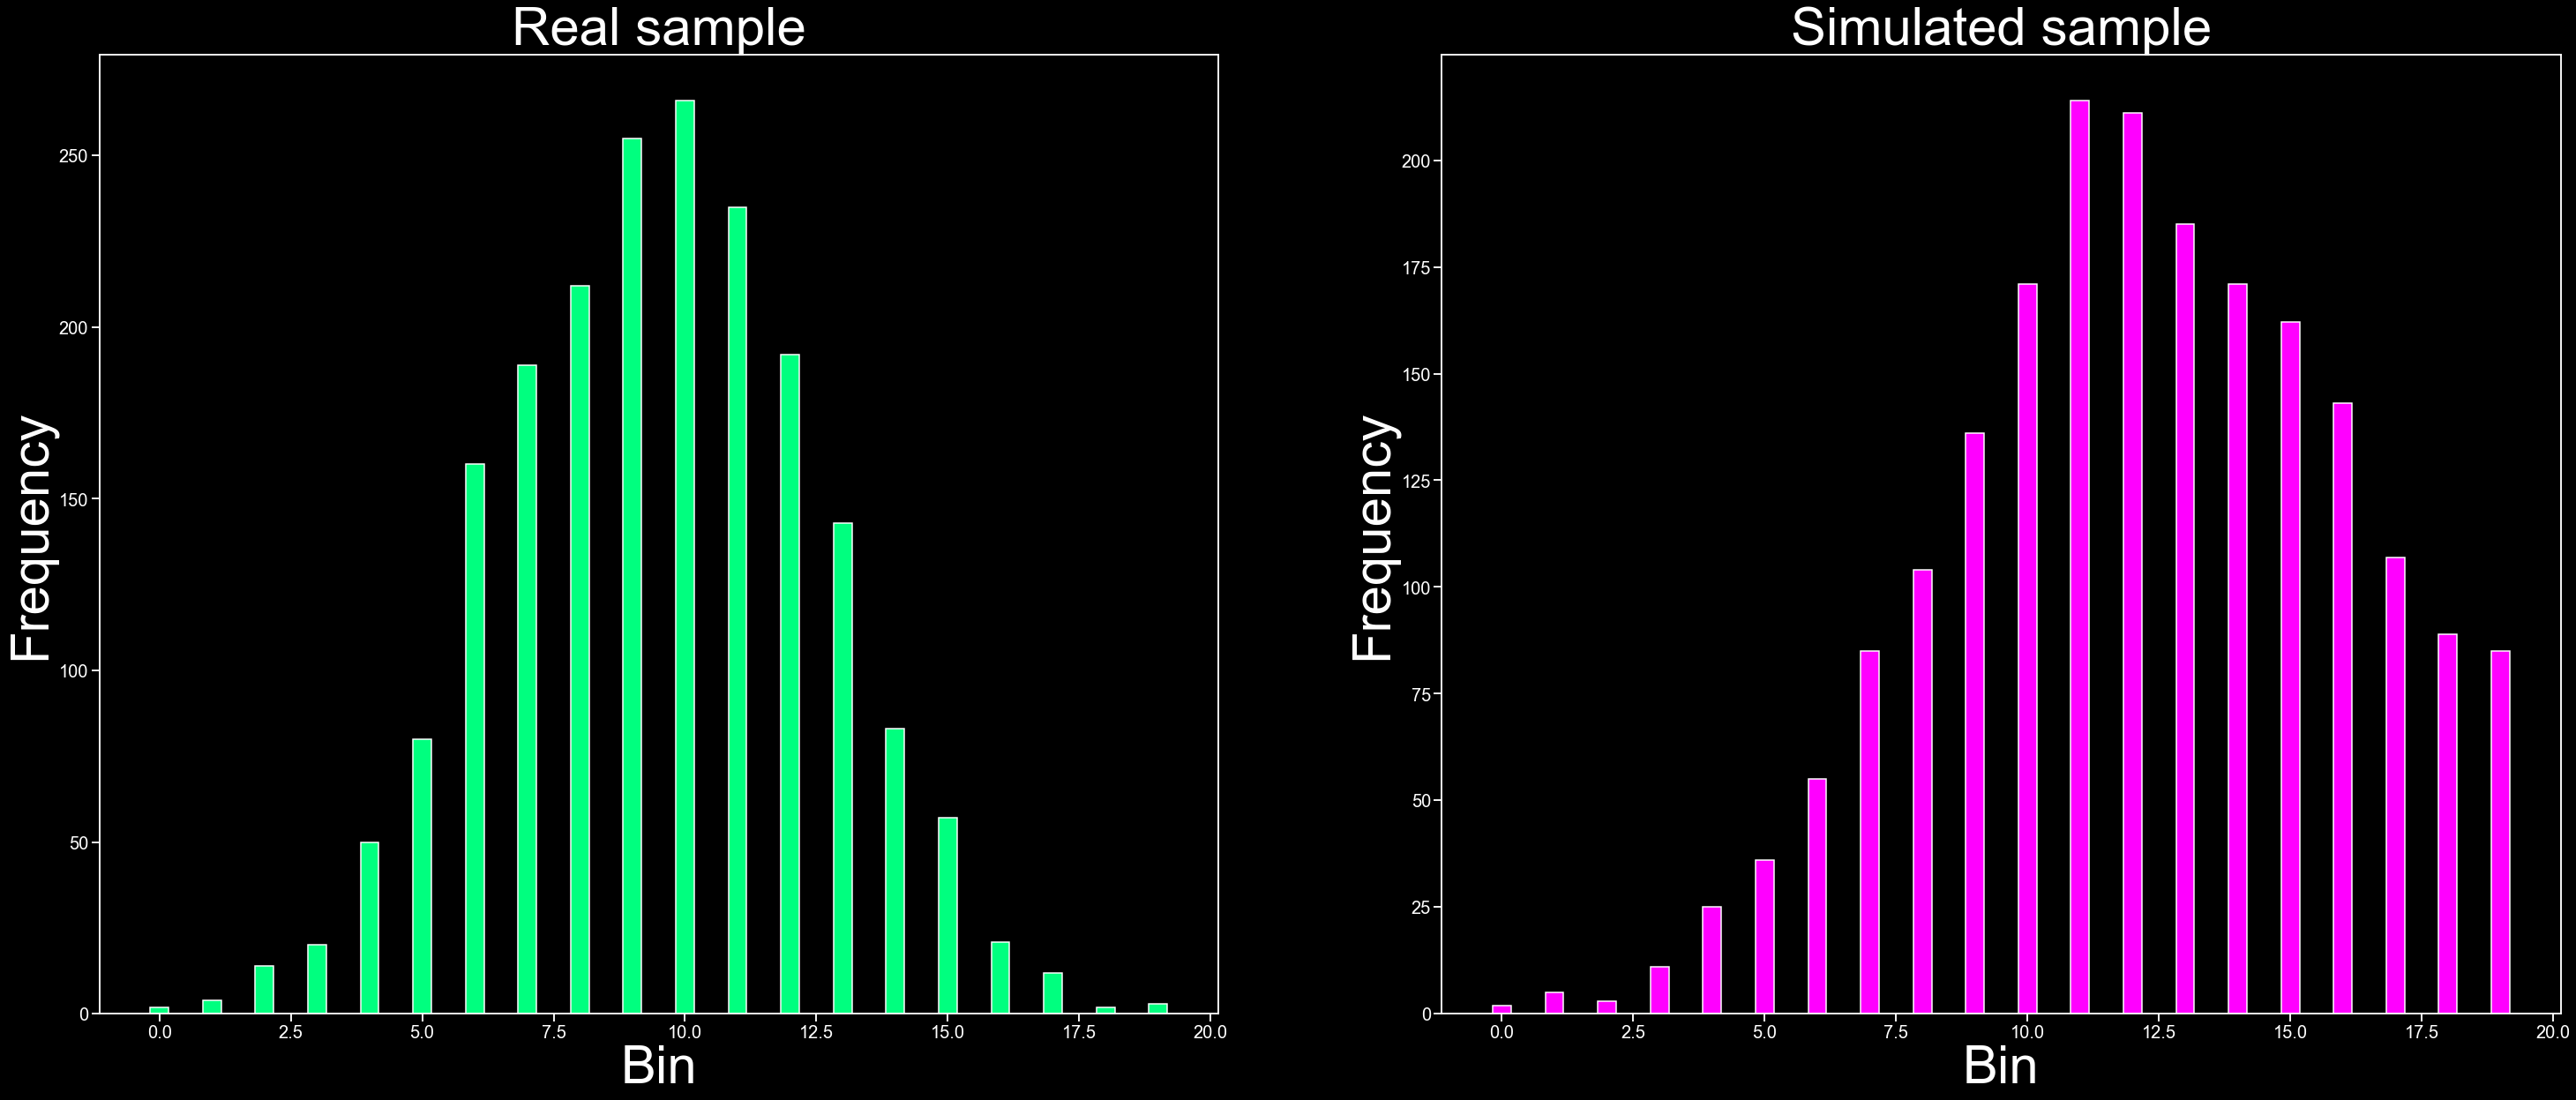

In [11]:
# To get a proper sense of what data we are working with, here we plot the histograms

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(50, 20))
ax1.bar(series_1_binned[1][:-1], 
        series_1_binned[0], 
        width=0.35, 
        color='SpringGreen')
ax2.bar(series_2_binned[1][:-1], 
        series_2_binned[0], 
        width=0.35, 
        color='Magenta')

ax1.set_title('Real sample',fontsize=60)
ax1.set_xlabel('Bin',fontsize=60)
ax1.set_ylabel('Frequency',fontsize=60)
ax2.set_title('Simulated sample',fontsize=60)
ax2.set_xlabel('Bin',fontsize=60)
ax2.set_ylabel('Frequency',fontsize=60)


In [12]:
# Now we calculate the cumulative frequencies of the distributions. This just means looking at 
# each bin and calculating how many data points fit into this bin or lower

series_1_cumulative_frequency = series_1_binned[0].cumsum()
series_2_cumulative_frequency = series_2_binned[0].cumsum()
print(series_1_cumulative_frequency)

[   2    6   20   40   90  170  330  519  731  986 1252 1487 1679 1822
 1905 1962 1983 1995 1997 2000]


Text(0, 0.5, 'Frequency')

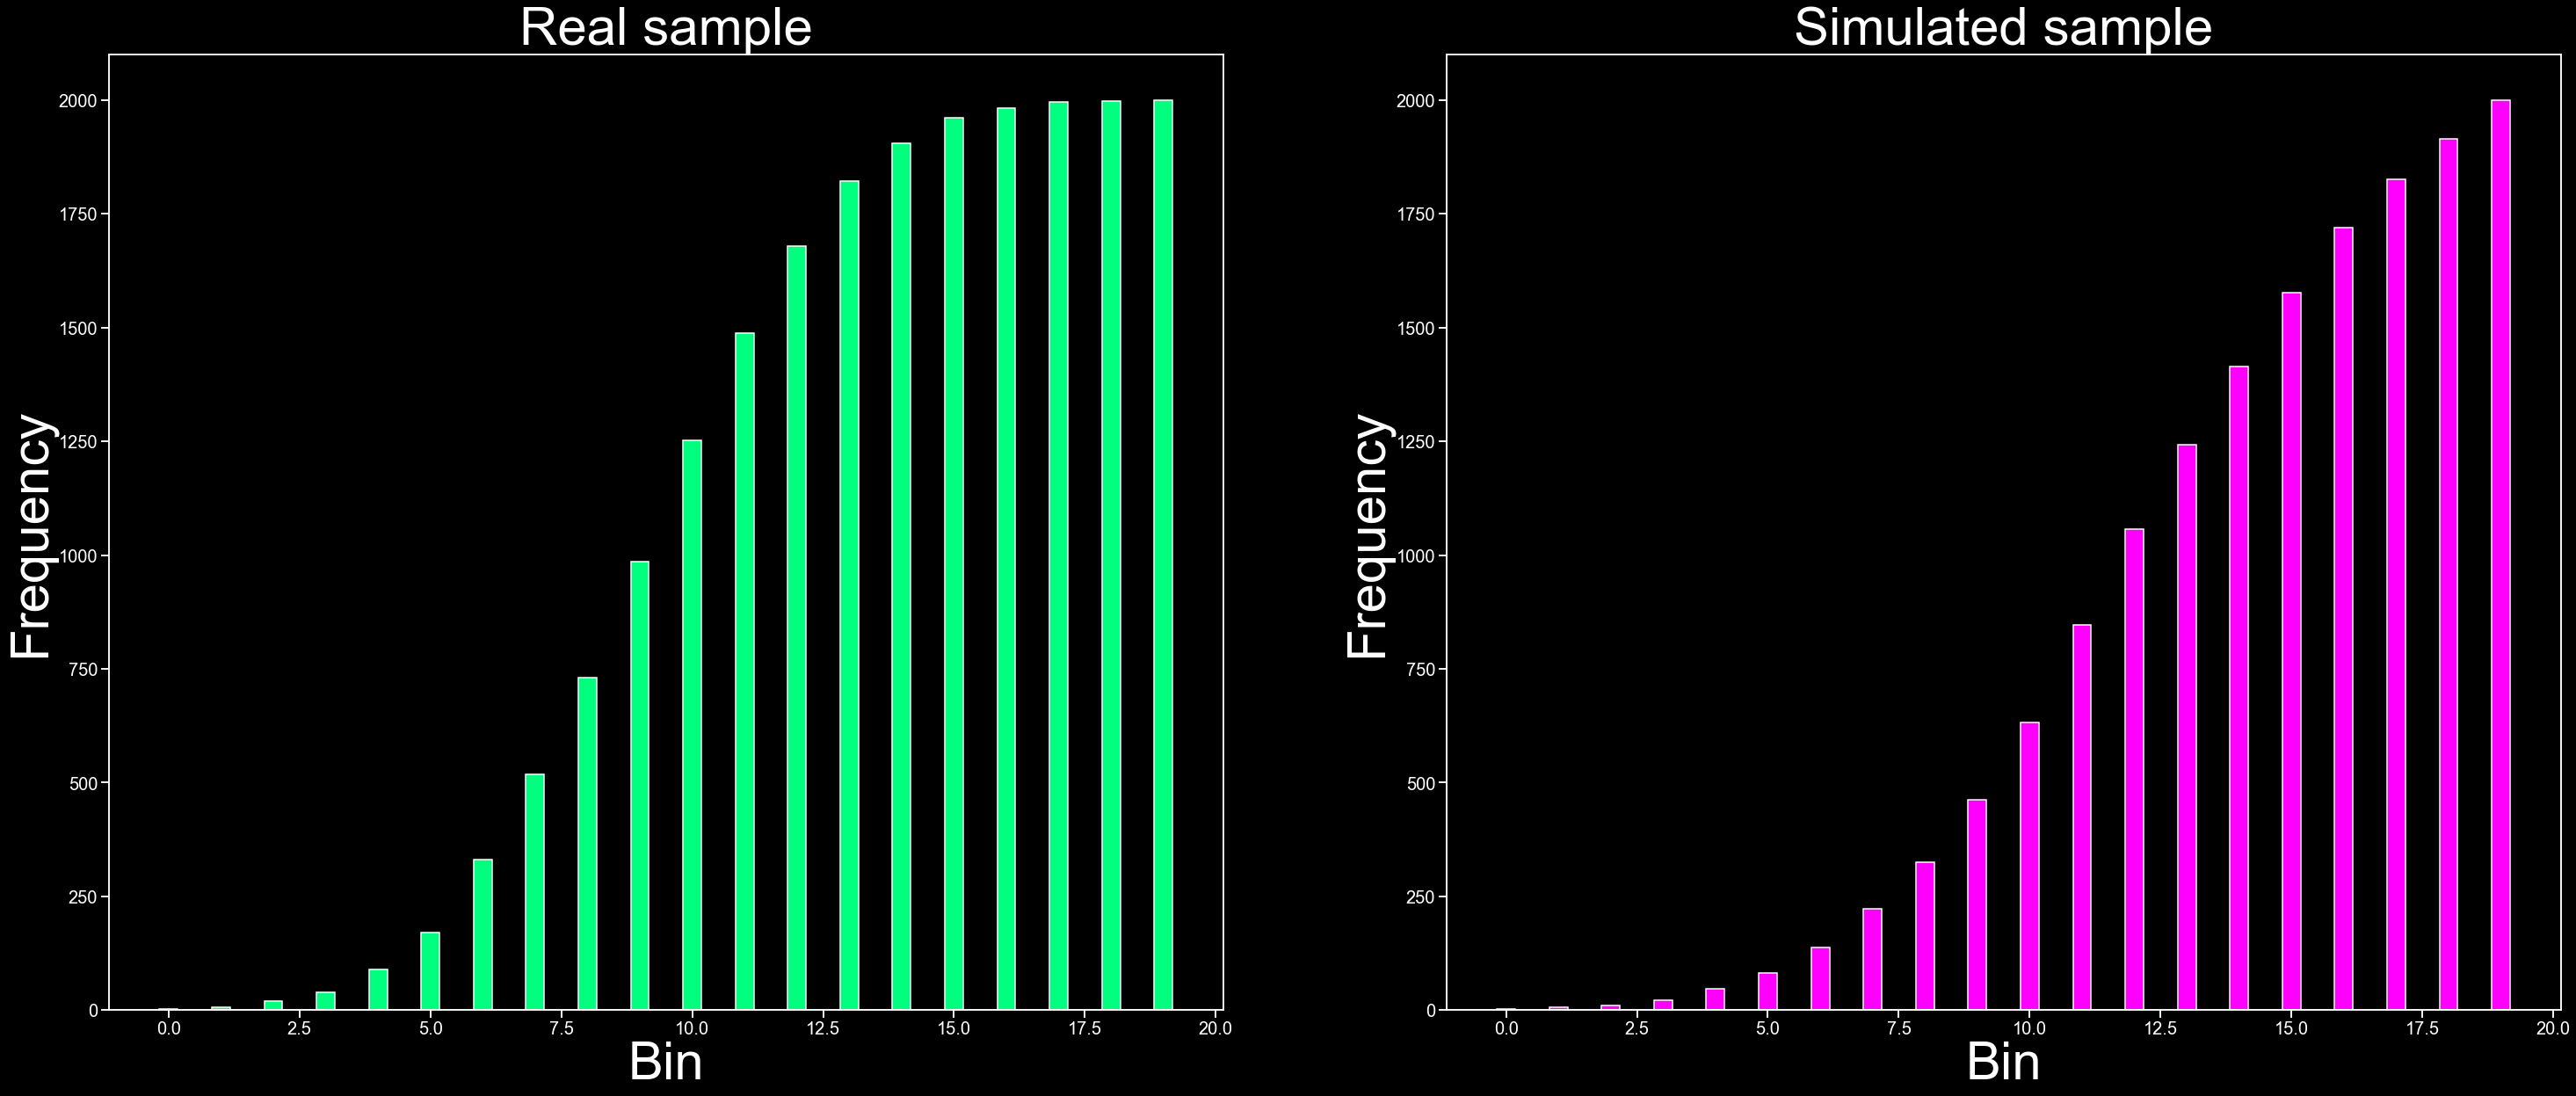

In [13]:
# Visualise cumulative frequency data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(50, 20))
ax1.bar(series_1_binned[1][:-1], 
        series_1_cumulative_frequency, 
        width=0.35, 
        color='SpringGreen')
ax2.bar(series_1_binned[1][:-1], 
        series_2_cumulative_frequency, 
        width=0.35, 
        color='Magenta')

ax1.set_title('Real sample',fontsize=60)
ax1.set_xlabel('Bin',fontsize=60)
ax1.set_ylabel('Frequency',fontsize=60)
ax2.set_title('Simulated sample',fontsize=60)
ax2.set_xlabel('Bin',fontsize=60)
ax2.set_ylabel('Frequency',fontsize=60)

In [14]:
"""
Next we calculate the cumulative frequency proportions of the distributions.
this is known as an empirical distribution function -  edf and all it is,
is the cumulative distribution function, but instead of having the number of data points falling 
in each on the y-axis, we know have the proportion of points falling in each bin.
"""

series_1_edf = series_1_binned[0].cumsum()/series_1_binned[0].sum()
series_2_edf = series_2_binned[0].cumsum()/series_2_binned[0].sum()
print(series_1_edf)

[0.001  0.003  0.01   0.02   0.045  0.085  0.165  0.2595 0.3655 0.493
 0.626  0.7435 0.8395 0.911  0.9525 0.981  0.9915 0.9975 0.9985 1.    ]


Text(0, 0.5, 'Frequency')

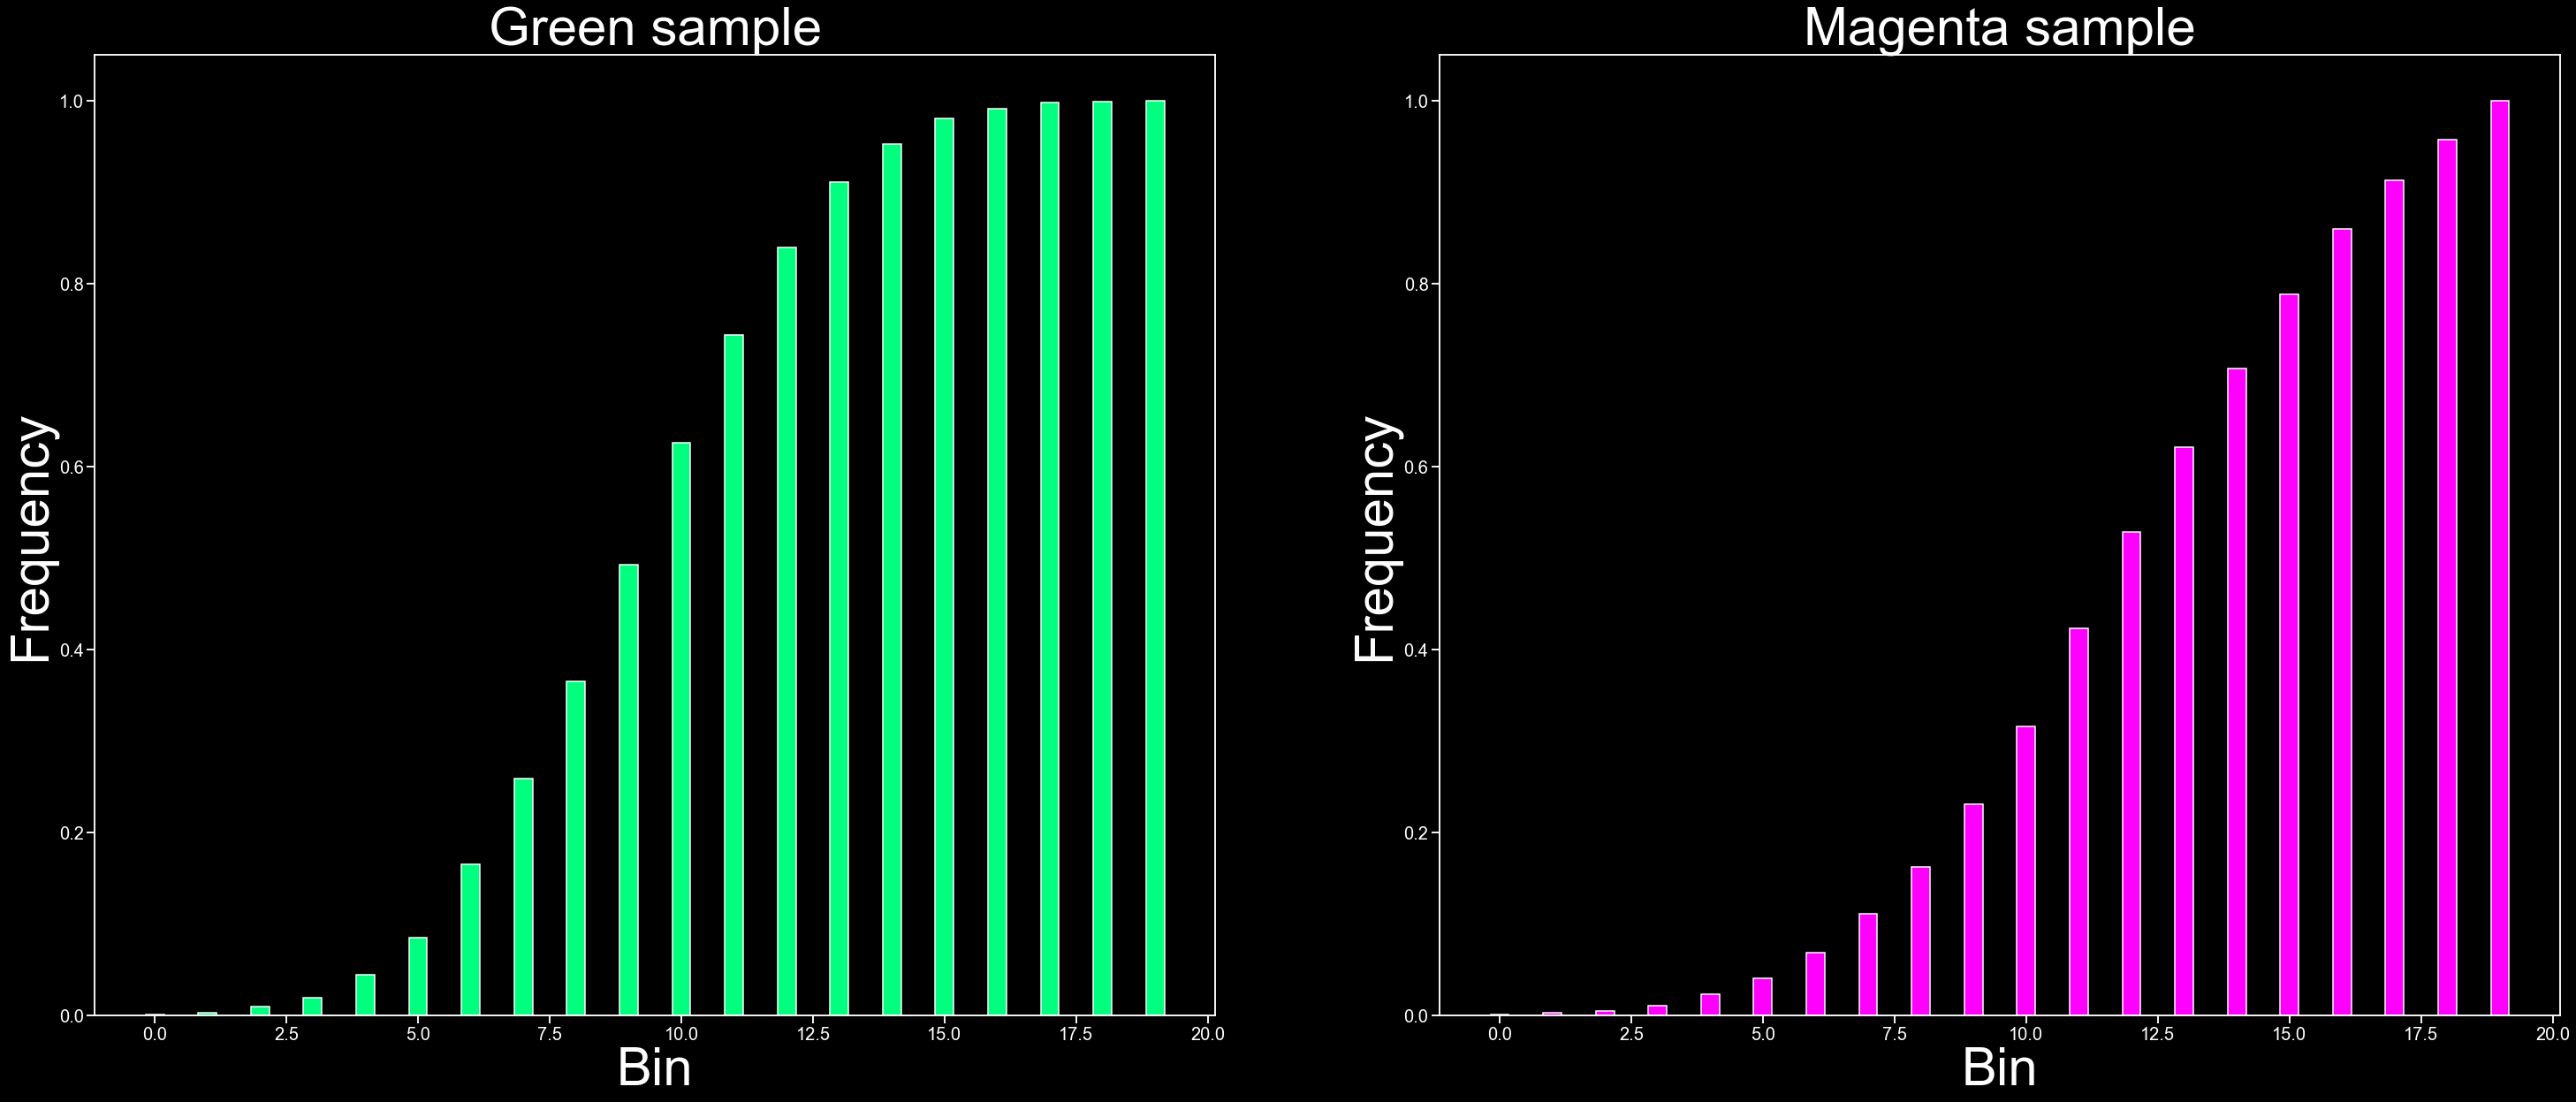

In [15]:
# Visualise EDF

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(50, 20))
ax1.bar(series_1_binned[1][:-1], 
        series_1_edf, 
        width=0.35, 
        color='SpringGreen')
ax2.bar(series_1_binned[1][:-1], 
        series_2_edf, 
        width=0.35, 
        color='Magenta')

ax1.set_title('Green sample',fontsize=60)
ax1.set_xlabel('Bin',fontsize=60)
ax1.set_ylabel('Frequency',fontsize=60)
ax2.set_title('Magenta sample',fontsize=60)
ax2.set_xlabel('Bin',fontsize=60)
ax2.set_ylabel('Frequency',fontsize=60)

In [16]:
# Here we have generated two lists of proportions, one from each sample.

print("Edf first distribution: " + str(series_1_edf))
print("Edf second distribution: " + str(series_2_edf))
print()
print("Difference between arrays" + str(abs(series_1_edf-series_2_edf)))

Edf first distribution: [0.001  0.003  0.01   0.02   0.045  0.085  0.165  0.2595 0.3655 0.493
 0.626  0.7435 0.8395 0.911  0.9525 0.981  0.9915 0.9975 0.9985 1.    ]
Edf second distribution: [0.001  0.0035 0.005  0.0105 0.023  0.041  0.0685 0.111  0.163  0.231
 0.3165 0.4235 0.529  0.6215 0.707  0.788  0.8595 0.913  0.9575 1.    ]

Difference between arrays[0.     0.0005 0.005  0.0095 0.022  0.044  0.0965 0.1485 0.2025 0.262
 0.3095 0.32   0.3105 0.2895 0.2455 0.193  0.132  0.0845 0.041  0.    ]


In [17]:
"""
We take the two lists and then subtract them from one another. This is akin to taking each bar 
in the green EDF and comparing it to the bar in the same position in the magenta EDF.
Now the crux of the KS test is to find the biggest difference between two corresponding bars.
The bigger it is, the less the probability that the two are drawn from the same distribution.
"""

dmax = max(abs(series_1_edf-series_2_edf))
print(dmax)

0.32000000000000006


In [19]:
# Confirm that dmax is equal to the test statistic outputted by the ks_2samp function

computed_ks = stats.ks_2samp(first_normal_random_list, second_normal_random_list)
print(computed_ks)

KstestResult(statistic=0.32, pvalue=6.268805293161945e-91)




So we understand how to get to the test statistic, but how does this relate to the p-value? The p value corresponds to a threshold distance, above which it is unlikely that the two samples are drawn from the same distribution. To calculate this threshold distance we first look up the constant corresponding to the confidence level we are testing.

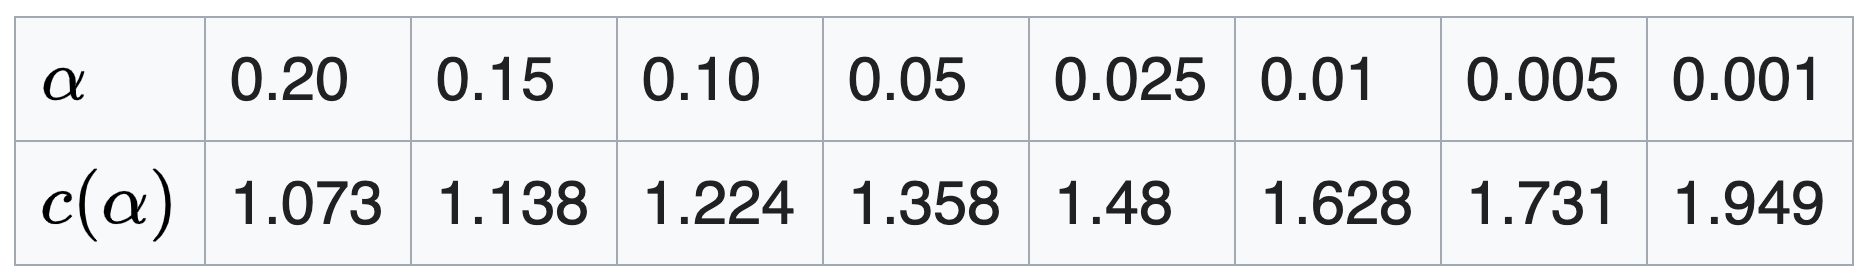

In [20]:
# It's a norm to use 0.05, so we'll use that as an example.
alpha = 1.358

Next we plug this into the threshold formula which takes into account how many observations there are in each sample (represented by 'n' and 'm').

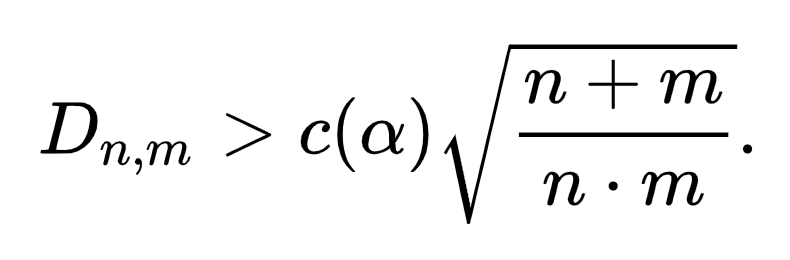

In [21]:
threshold_distance = alpha * math.sqrt((first_distribution_number_samples+second_distribution_number_samples)/
                                       (first_distribution_number_samples*second_distribution_number_samples))
print("Threshold distance is: " + str(threshold_distance))
print("Distance in our distribution is: " + str(dmax))

Threshold distance is: 0.04294373062508659
Distance in our distribution is: 0.32000000000000006


At this point we'll explore how to use the KS test in ABM calibration. The KS test provides a measure of distance (difference) between two samples. In calibration we want to minimise this difference. At times it makes sense for this to be done automatically. Here we use algorithms from nevergrad - a library of optimisation algorithms developed by Facebook's AI research team.

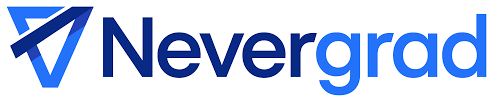

In [22]:
# After running 'pip install nevergrad'
import nevergrad as ng

In [23]:
# Define a loss function
def function(x):
    return (x - .5)**2

In [24]:
# Do a grid search on the loss function
grid_search = np.linspace(0,1,1000)

loss_list = []
for x_value in grid_search:
    loss_list.append(function(x_value))

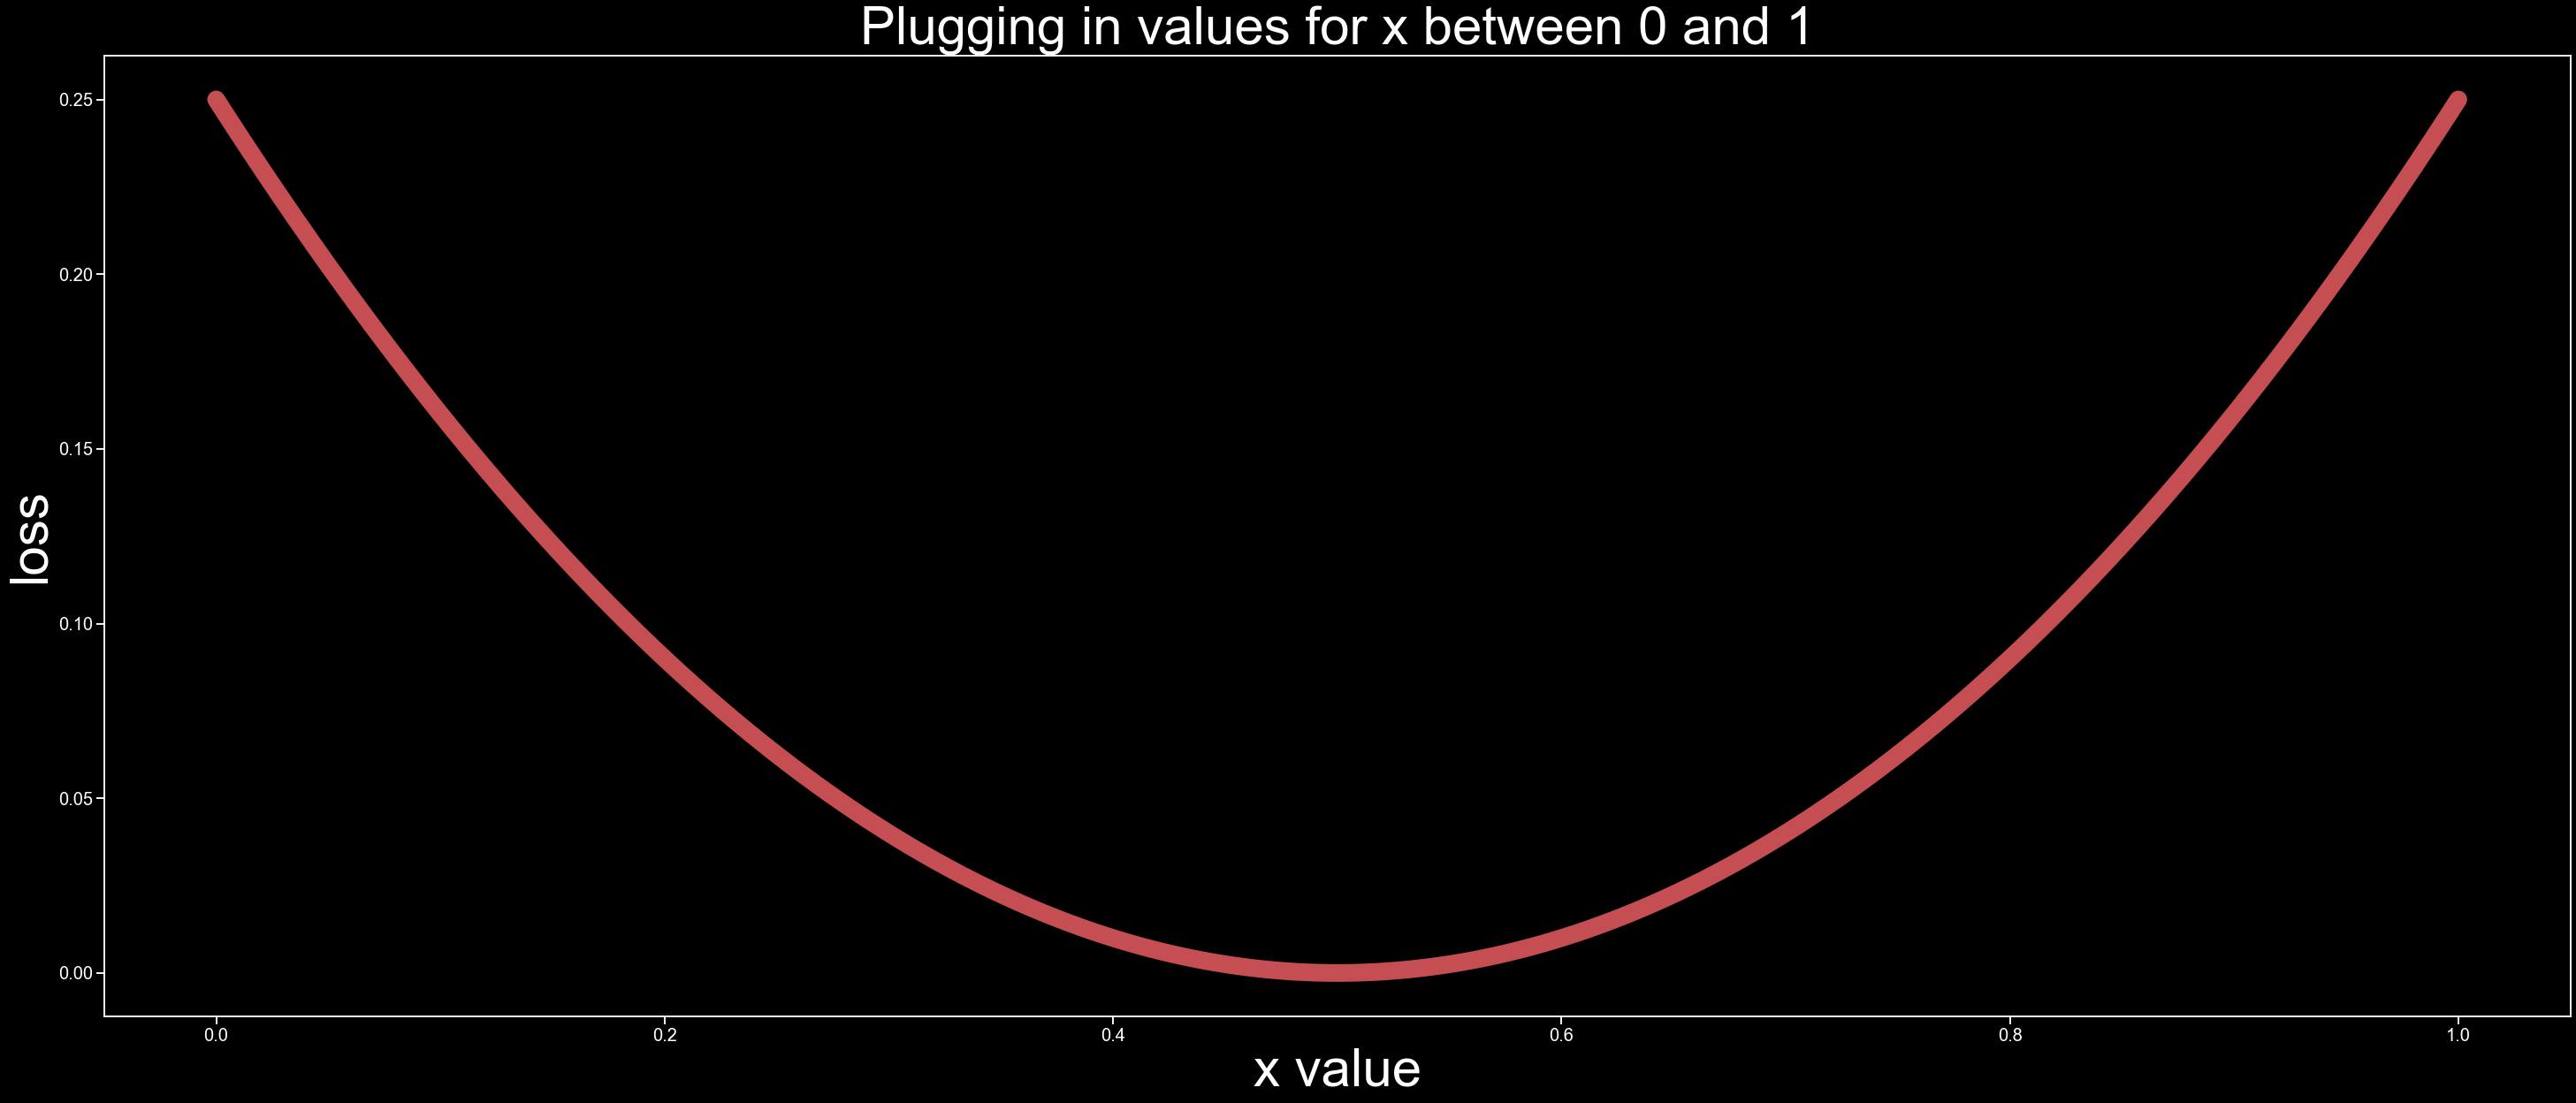

In [25]:
# Plot the loss function

fig, (ax1) = plt.subplots(1,1, figsize=(50, 20))

ax1.set_title('Plugging in values for x between 0 and 1',fontsize=60)
ax1.set_xlabel('x value',fontsize=60)
ax1.set_ylabel('loss',fontsize=60)
    
ax1 = plt.plot(grid_search,loss_list, lw=20, color='r')

In [26]:
"""
A simple nevergrad algorithm is OnePlusOne. Here we can pass in the function and the algorithm
will try many options and at the end give us the one that had the best results in minimising the
loss function
"""

# Optimization on x as an array of shape (1,)
optimizer = ng.optimizers.OnePlusOne(parametrization=1, 
                                     budget=100)
recommendation = optimizer.minimize(function)  # best value
print(recommendation.value[0])

0.4999754805471167


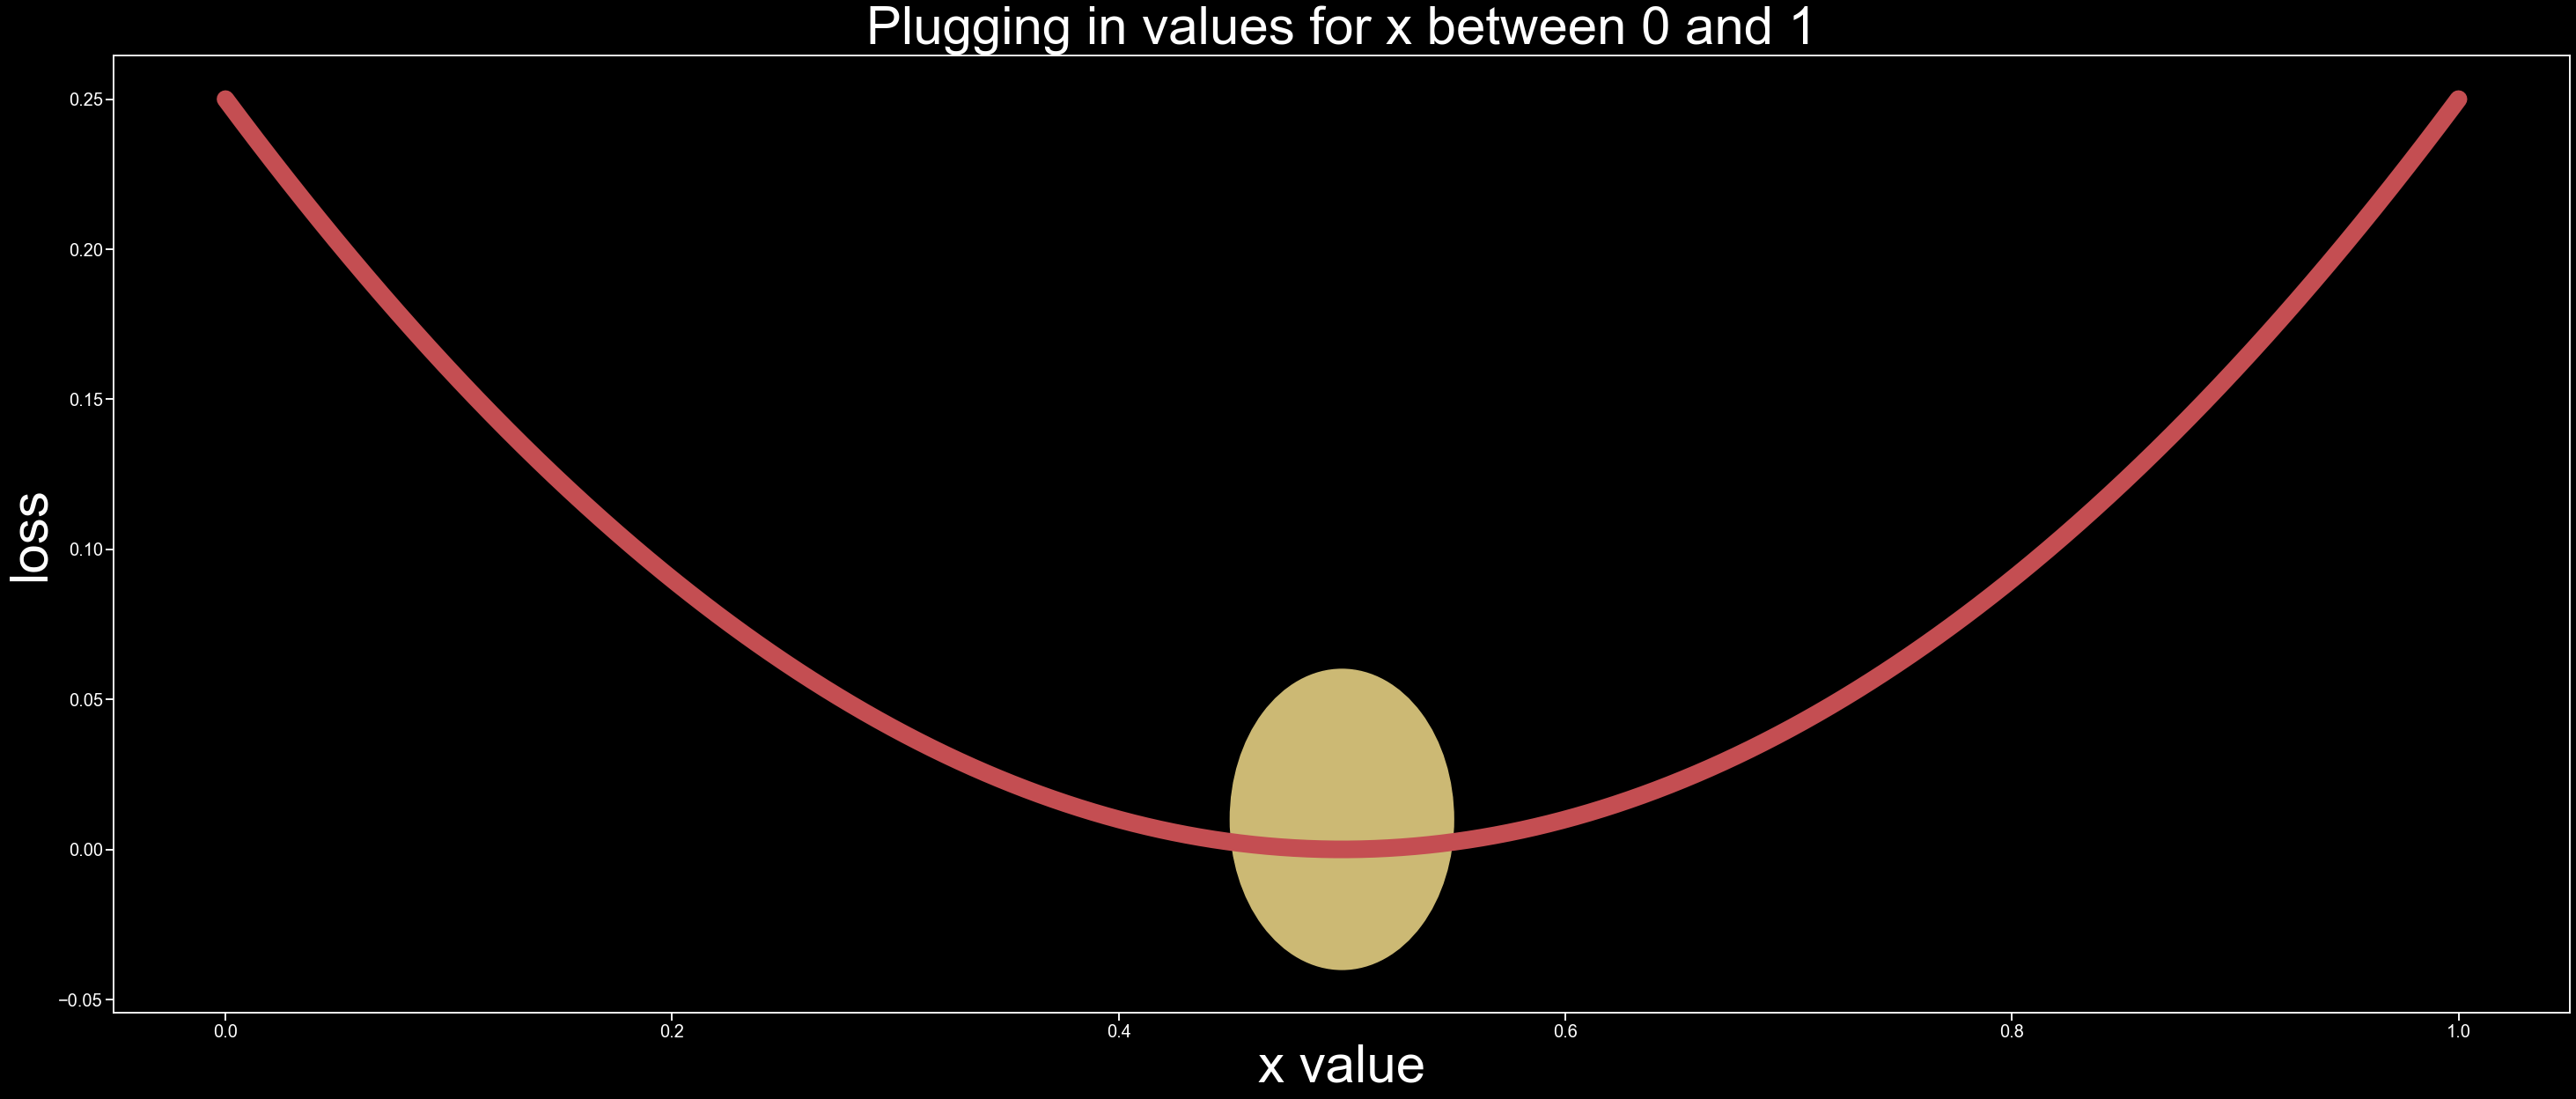

In [27]:
# If we visualise where this recommendation lands, it does appear to fit on the global minimum

fig, (ax1) = plt.subplots(1,1, figsize=(50, 20))

ax1.set_title('Plugging in values for x between 0 and 1',fontsize=60)
ax1.set_xlabel('x value',fontsize=60)
ax1.set_ylabel('loss',fontsize=60)

circ = plt.Circle(((recommendation.value[0]), 0.01), 0.05, color='y')
    
min_loss = patches.Circle(1,1)
ax1.add_patch(circ)    

ax1 = plt.plot(grid_search,loss_list, lw=20, color='r')

Now let's apply this to the distributions we generated earlier and minimise the loss using the KS test as a loss function.

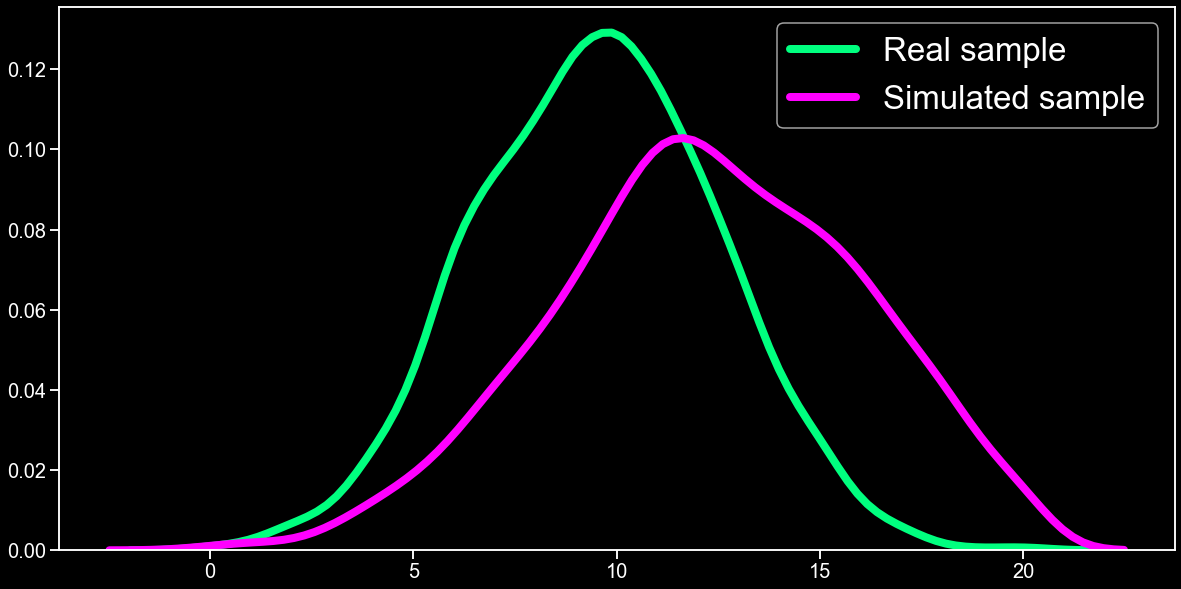

In [28]:
# Recall the two distributions from before

ax = plt.subplots(figsize=(20, 10))
ax = sns.kdeplot(first_normal_random_list, 
            color='SpringGreen', 
            shade=False, 
            label='Real sample',
            linewidth=8)
ax = sns.kdeplot(second_normal_random_list, 
            color='magenta', 
            shade=False, 
            label='Simulated sample',
            linewidth=8)

In [29]:
"""
Create a KS-based loss function which generates the magenta distribution
Recall that as a starting point, the green and magenta samples are drawn 
from distributions generated with different parameters. Here the optimisation
will serve to try and recover the parameters.

second_distribution_mean = 13
second_distribution_std = 4

versus

first_distribution_mean = 10
first_distribution_std = 3
"""


second_distribution_number_samples = 200 # Decrease N to save time
parameters = [second_distribution_mean, second_distribution_std]

def generate_second_distribution(parameters):

    # Generate second distribution
    second_normal_random_list = []
    while len(second_normal_random_list) < second_distribution_number_samples:
        
        random_number = int(np.random.normal(loc=parameters[0], scale=abs(parameters[1])))
        
        if demo_min <= random_number <= demo_max:
            second_normal_random_list.append(random_number)
            
    # Check the loss using the KS function
    computed_ks = stats.ks_2samp(first_normal_random_list, second_normal_random_list)

    # Return the loss
    return computed_ks[0]
    

In [30]:
# Dmax - the KS test statistic is the loss for this function. This is what we will aim to minimise
generate_second_distribution(parameters)

0.3835

In [31]:
# Now minimise the loss function 

# Optimization on x as an array of shape (2,)
parametrization = ng.p.Array(init=[second_distribution_mean,
                                  second_distribution_std])


optimizer = ng.optimizers.OnePlusOne(parametrization=parametrization, # What's the starting point
                                     budget=1000)                       # How much time to spend on optimisation


recommendation = optimizer.minimize(generate_second_distribution)     # Best value
print(recommendation.value)

[9.8833779  3.29329408]


In [32]:
parameters = [recommendation.value[0],
              recommendation.value[1]]

In [33]:
# Now let's generate magenta distribution using the new parameters and judge how similar
# The distributions now appear

second_normal_random_list = []
while len(second_normal_random_list) < second_distribution_number_samples:
    
    random_number = int(np.random.normal(loc=parameters[0], 
                                     scale=parameters[1]))
    
    if demo_min <= random_number <= demo_max:
        second_normal_random_list.append(random_number)


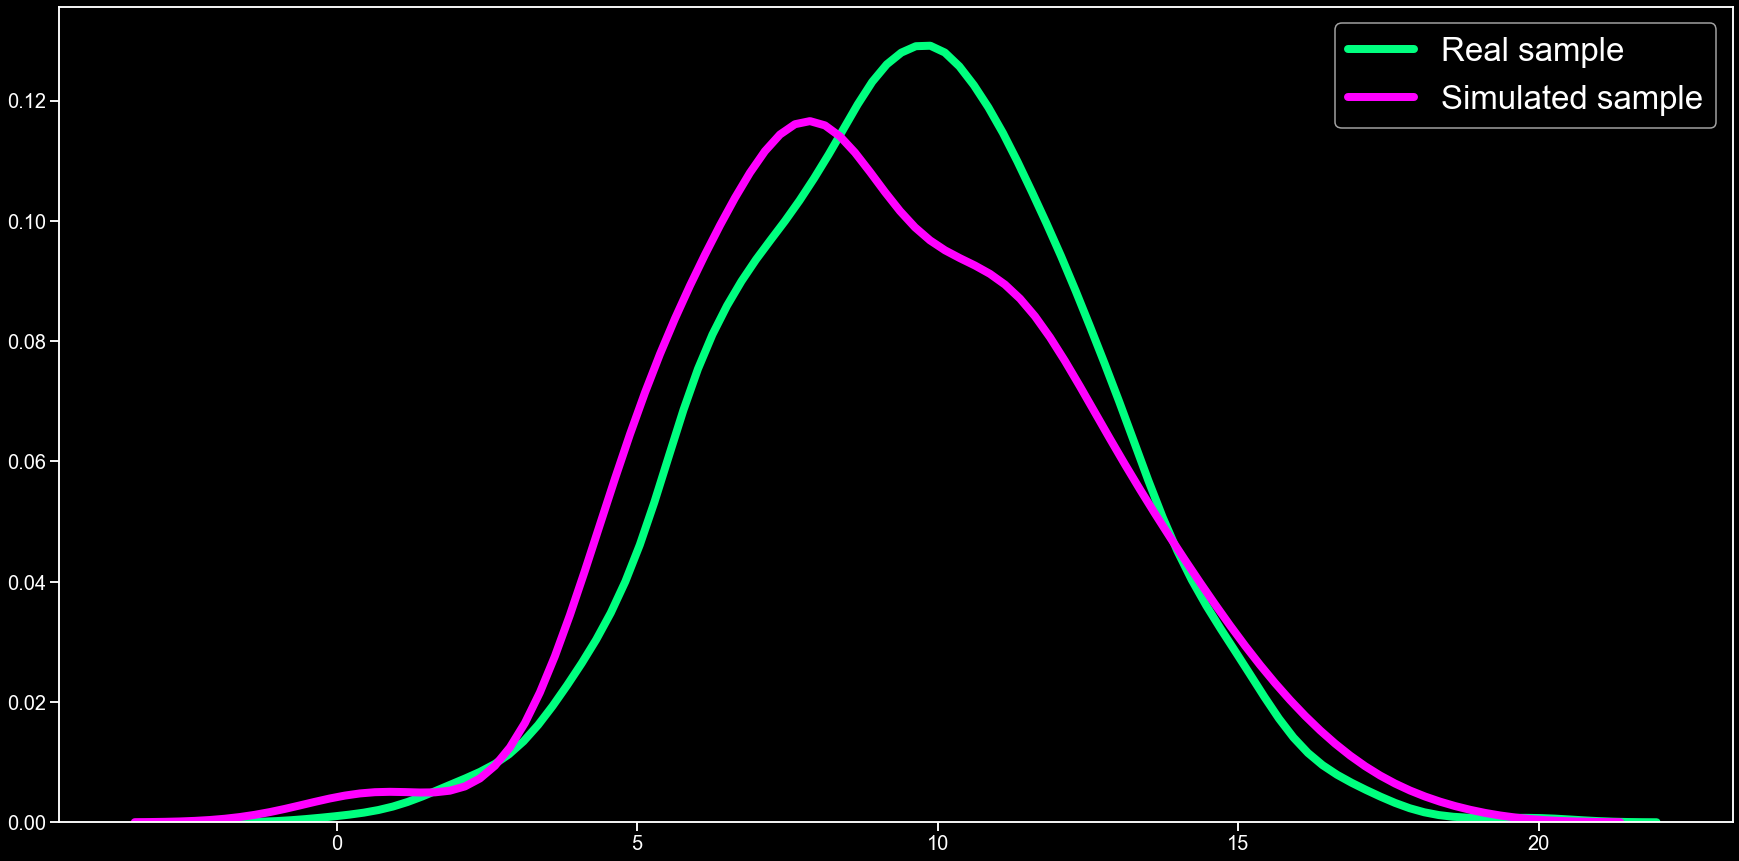

In [35]:
ax = plt.subplots(figsize=(30, 15))
ax = sns.kdeplot(first_normal_random_list, 
            color='SpringGreen', 
            shade=False, 
            label='Real sample',
            linewidth=8)
ax = sns.kdeplot(second_normal_random_list, 
            color='magenta', 
            shade=False, 
            label='Simulated sample',
            linewidth=8)